###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, heterogeneous models are from [this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/The Finite-Difference Method/fd_ac2d_heterogeneous.ipynb) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Florian Wölfl and Lion Krischer ([@krischer](https://github.com/krischer)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/), notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D acoustic FD modelling for heterogeneous media

So far, we only compared 2D acoustic FD modelling results for homogeneous acoustic media with analytical solutions. Next, we want to model some more interesting, heterogeneous problems. 

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# Definition of initial modelling parameters
# ------------------------------------------
xmax = 2000.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax   # maximum spatial extension of the 1D model in z-direction (m)
dx   = 10.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)

tmax = 0.75    # maximum recording time of the seismogram (s)
dt   = 0.0010 # time step

vp0  = 3000.  # P-wave speed in medium (m/s)

# acquisition geometry
xsrc = 1000.0 # x-source position (m)
zsrc = xsrc   # z-source position (m)

f0   = 100.0 # dominant frequency of the source (Hz)
t0   = 0.1   # source time shift (s)

isnap = 2  # snapshot interval (timesteps)

In [4]:
@jit(nopython=True) # use JIT for C-performance
def update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
                
            d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
            d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
    return d2px, d2pz   

In [5]:
# Define simple absorbing boundary frame based on wavefield damping 
# according to Cerjan et al., 1985, Geophysics, 50, 705-708
def absorb(nx,nz):

    FW = 60     # thickness of absorbing frame (gridpoints)    
    a = 0.0053
    
    coeff = np.zeros(FW)
    
    # define coefficients in absorbing frame
    for i in range(FW):    
        coeff[i] = np.exp(-(a**2 * (FW-i)**2))

    # initialize array of absorbing coefficients
    absorb_coeff = np.ones((nx,nz))

    # compute coefficients for left grid boundaries (x-direction)
    zb=0 
    for i in range(FW):
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[i,j] = coeff[i]

    # compute coefficients for right grid boundaries (x-direction)        
    zb=0
    for i in range(FW):
        ii = nx - i - 1
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[ii,j] = coeff[i]

    # compute coefficients for bottom grid boundaries (z-direction)        
    xb=0 
    for j in range(FW):
        jj = nz - j - 1
        xb = j
        xe = nx - j
        for i in range(xb,xe):
            absorb_coeff[i,jj] = coeff[j]

    return absorb_coeff

In [6]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
def FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc):        
    
    # define model discretization
    # ---------------------------

    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)

    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)

    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)

    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2)) 
    
    # define clip value: 0.1 * absolute maximum value of source wavelet
    clip = 0.1 * max([np.abs(src.min()), np.abs(src.max())]) / (dx*dz) * dt**2
    
    # Define absorbing boundary frame
    # -------------------------------    
    absorb_coeff = absorb(nx,nz)
    
    # Define model
    # ------------    
    vp  = np.zeros((nx,nz))
    vp  = model(nx,nz,vp,dx,dz)    
    vp2 = vp**2
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p    
    
    # Initalize animation of pressure wavefield 
    # -----------------------------------------    
    fig = plt.figure(figsize=(7,3.5))  # define figure size
    plt.tight_layout()
    extent = [0.0,xmax,zmax,0.0]     # define model extension
    
    # Plot pressure wavefield movie
    ax1 = plt.subplot(121)
    image = plt.imshow(p.T, animated=True, cmap="RdBu", extent=extent, 
                          interpolation='nearest', vmin=-clip, vmax=clip)        
    plt.title('Pressure wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')    
    
    # Plot Vp-model
    ax2 = plt.subplot(122)
    image1 = plt.imshow((vp.T)/1000, cmap=plt.cm.viridis, interpolation='nearest', 
                        extent=extent)
    
    plt.title('Vp-model')
    plt.xlabel('x [m]')
    plt.setp(ax2.get_yticklabels(), visible=False) 
    
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(image1, cax=cax2)         
    plt.ion()    
    plt.show(block=False)
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        d2px, d2pz = update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz)

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
        
        # Apply absorbing boundary frame
        # ------------------------------
        p *= absorb_coeff
        pnew *= absorb_coeff
        
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # display pressure snapshots 
        if (it % isnap) == 0:
            image.set_data(p.T)
            fig.canvas.draw()  
            
    return vp        

## Problem 1: Homogeneous Model

As a reference, we start with a problem, which should be quite familiar to you - the homogeneous model. I modified the FD code to define models in a separate Python function:

In [7]:
# Homogeneous model
def model(nx,nz,vp,dx,dz):
    
    vp += vp0 
    
    return vp

Time to define the modelling parameters and run the new FD code ...

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


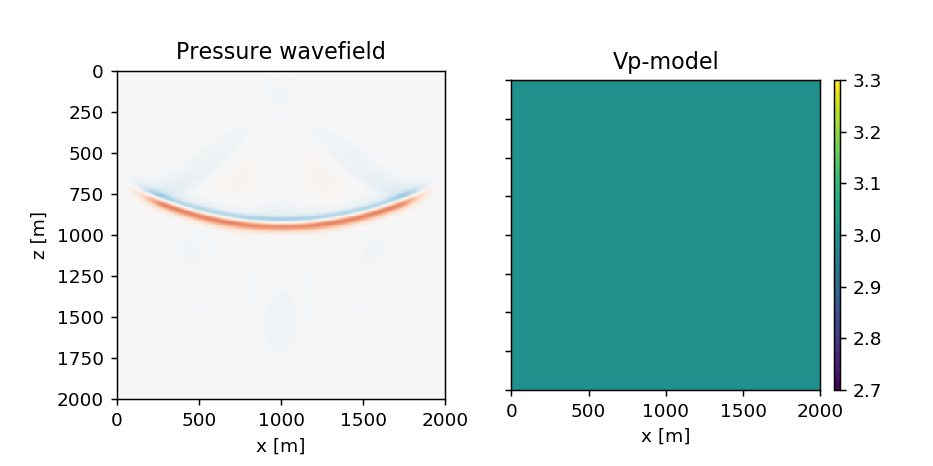

In [8]:
%matplotlib notebook
xsrc = 1000.0 # x-source position (m)
zsrc = xsrc   # z-source position (m)

dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vp0)

vp_hom = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

## Problem 2: Random Medium

Next, we add some random perturbations to the homogeneous Vp-model:

In [9]:
# Random medium model
def model(nx,nz,vp,dx,dz):
        
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    vp += vp0 * (1 + r)
    
    return vp

nx =  400
nz =  400
nt =  890


<IPython.core.display.Javascript object>


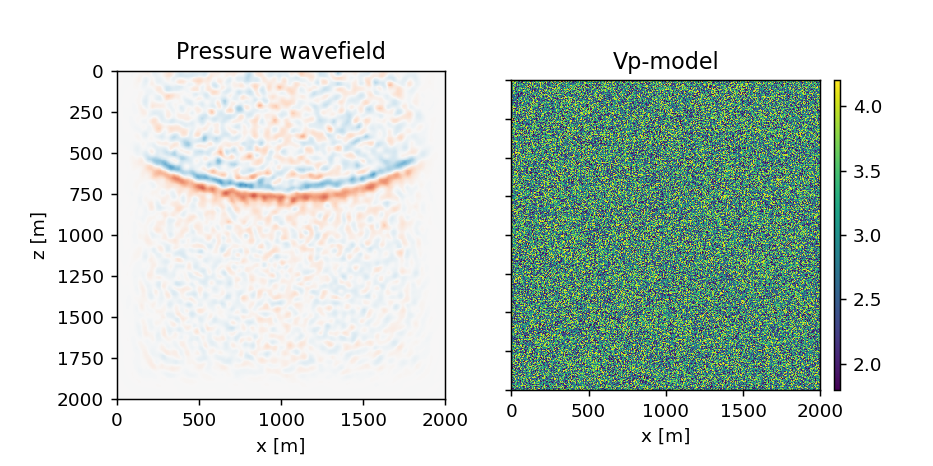

In [10]:
xsrc = 1000.0 # x-source position (m)
zsrc = xsrc    # z-source position (m)

dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)
vpmax = 4200.0
# vpmax = np.max(vp0)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_rand = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

## Problem 3: Fault Zone

In this problem, we model acoustic wave propagation in a vertical fault zone

In [11]:
# Vertical fault zone model
def model(nx,nz,vp,dx,dz):
    
    fault_ext = 25.0           # half-extension of the fault in x-direction (m)
    n_ft = (int)(fault_ext/dx) # half-extension of the fault in x-direction (gridpoints)
    vp += vp0
    vp[nx // 2 - n_ft: nx // 2 + n_ft,:] *= 0.8     
        
    return vp

nx =  400
nz =  400
nt =  890


<IPython.core.display.Javascript object>


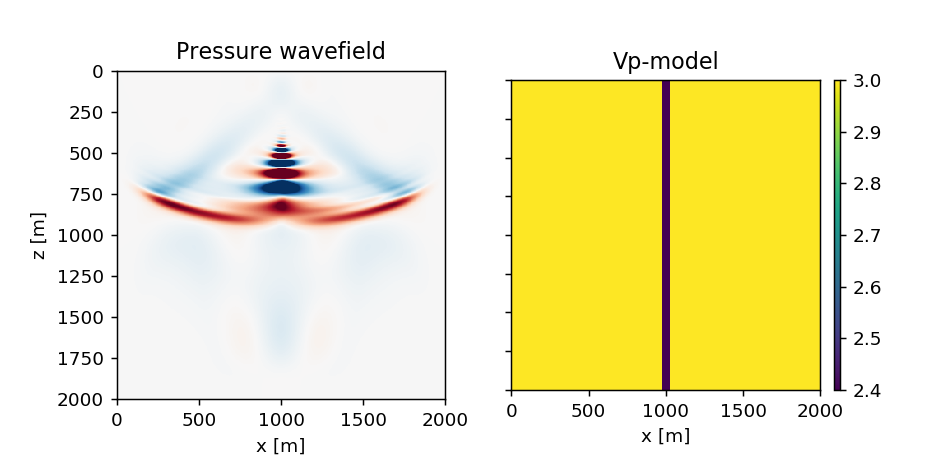

In [12]:
xsrc = 1000.0 # x-source position (m)
zsrc = 1000.0 # z-source position (m)

dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)
vpmax = 4200.0
# vpmax = np.max(vp0)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_fault = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

## Problem 4: Simplified Vulcano

How does the surface topography of a vulcano scatter the acoustic wavefield?

In [13]:
# Simplified vulcano (Gaussian hill)
def model(nx,nz,vp,dx,dz):
    
    vp += vp0 # fill model with vp0
    
    for i in range(0,nx):
        for j in range(0,nz):
            
            depth = j * dz  # depth of grid point j (m)
            x = i * dx      # horizontal distance of grid point i (m)
            
            x_center = (int)(nx/2) * dx  # center of vulcano cone            
            height_vul = 1500.0          # vulcano height
            sigma = 500.0                # half-width of vulcano cone
            
            # approximate vulcano topography by Gaussian hill
            topo = - height_vul * np.exp(-(x - x_center)**2/sigma**2) + dx*nz
            
            # add air above the topography
            if(depth < topo):
                vp[i,j] = 0.0
            
    return vp

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


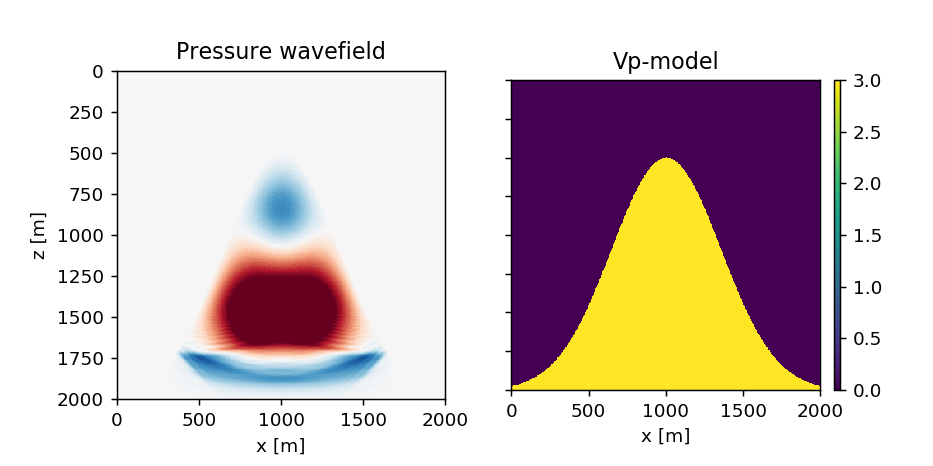

In [14]:
xsrc = 1000.0 # x-source position (m)
zsrc = 1250.0 # z-source position (m)

dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 4.5  # centre frequency of the source wavelet (Hz)
vpmax = vp0

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_topo = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

## Problem 4: Building velocity models based on images

It is a quite tedious approach to build complex velocity models via IF-statements in the FOR-loops over the Cartesian FD grid. Alternatively, you can read an image and match colors with seismic P-wave velocities. Be sure to use PNGs or other non-compression image formats in order to avoid problems with compression artifacts. As an introductory example, we use this "realistic" subsurface model:

In [15]:
# Build "realistic" subsurface model based on imported image

from scipy import misc # import image read from scipy

def model(nx,nz,vp,dx,dz):
    
    # read jpeg image - be sure that the number of pixels coincides 
    # with the number of grid points nx and ny of the FD model
    image = misc.imread('images/realistic_subsurface.png')
    image_red = image[:,:,0]  # extract red channel
    
    vp += vp0 # fill model with vp0
    
    for i in range(0,nx):
        for j in range(0,nz):
            
            # if image_red[j,i]==0, set vp = 0 m/s
            if(image_red[j,i]<100):
                vp[i,j] = 0.
                
    return vp

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


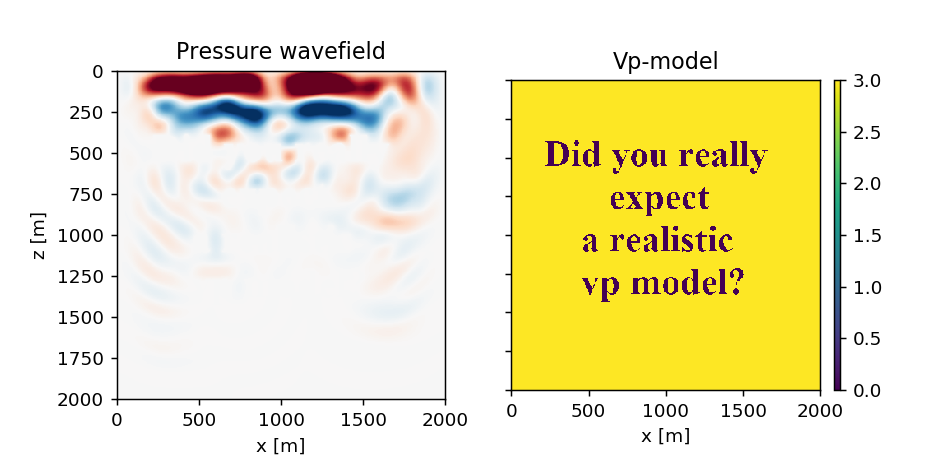

In [16]:
xsrc = 1000.0 # x-source position (m)
zsrc = 100.0  # z-source position (m)

dx   = 5.0    # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 40.    # centre frequency of the source wavelet (Hz)
vpmax = vp0

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_image = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

A little bit more realistic subsurface model ...

In [17]:
# Build more realistic subsurface model based on imported image

from scipy import misc # import image read from scipy

def model(nx,nz,vp,dx,dz):
    
    # read jpeg image - be sure that the number of pixels coincides 
    # with the number of grid points nx and ny of the FD model
    image = misc.imread('images/subsurface.png')
    image_red = image[:,:,0]  # extract red channel
    
    vp += vp0 # fill model with vp0
    
    for i in range(0,nx):
        for j in range(0,nz):
            
            # assume vaccum in the violet caves
            # if image_red[j,i]==128, set vp = 0 m/s
            vp[i,j] = 0.
            
            # if image_red[j,i]<50, set vp = 2000 m/s
            if(image_red[j,i]<112):
                vp[i,j] = 2000.
                
            # if image_red[j,i]>200, set vp = 3000 m/s
            if(image_red[j,i]>150):
                vp[i,j] = 2700.
                
    return vp

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


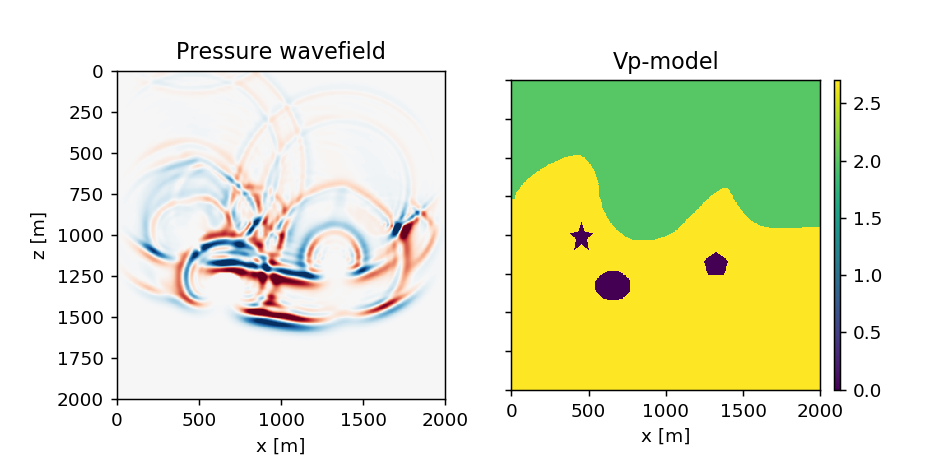

In [18]:
xsrc = 1000.0 # x-source position (m)
zsrc = 100.0  # z-source position (m)

dx   = 5.0    # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.   # centre frequency of the source wavelet (Hz)
vpmax = vp0

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_image = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

## Problem 6: Create your own problem here

##### Excercise

Now it's your turn, create a 2D P-wave velocity model and compute the pressure
wavefield by 2D acoustic FD modelling. Pay attention to satisfy the CFL and grid dispersion criteria by choosing appropriate spatial grid point distances $dx = dz$
and time step dt.

## What we learned:

- How to model wave propgation in simple heterogeneous 2D acoustic media 